In [86]:
import json
import gzip
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, accuracy, NormalPredictor, BaselineOnly, KNNBasic, SVD
#from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [2]:
df_review = pd.read_json('Data/Video_Games_5.json.gz', compression='gzip', lines=True)

In [ ]:
#df_tg_review = pd.read_json('Data/Toys_and_Games_5.json.gz', compression='gzip', lines=True)

In [3]:
df_prod = pd.read_json('Data/meta_Video_Games.json.gz', compression='gzip', lines=True)

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_tg_prod = getDF('Data/meta_Toys_and_Games.json.gz')

In [70]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [ ]:
df_review.info()

In [4]:
df_prod.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [5]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [6]:
df_prod['price']

'\n\t\t\t\t\t\t\t\t\t\t\t\t<span class="verticalAlign a-size-large"'

In [7]:
df_prod.drop(['tech1', 'fit', 'tech2', 'date', 'price', 'imageURLHighRes', 'details'], axis=1, inplace=True)

In [8]:
#pd.set_option('display.max_colwidth', None)
df_prod.iloc[[1, -1]]

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
1,"[Video Games, Xbox 360, Games, </span></span><...",[Brand new sealed!],Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
84818,"[Video Games, PC, Accessories, Gaming Mice]",[<b>Features and Functions:</b> <br>Quick thum...,Zelotes 4000 DPI Programmable Gaming Mouse for...,[],Zelotes,"[Customize DPI Switch: 1000/1500/2000/4000,the...",[>#434 in Computers & Accessories > Computer A...,"[B016ZF77OA, B00GU8W5AE, B00E64DTDQ, B074TF6XV...",Computers,,B01HJEBIAA,[https://images-na.ssl-images-amazon.com/image...


In [9]:
df_prod.head(20)

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]",[],Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, </span></span><...",[Brand new sealed!],Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...",[],street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...",[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,Xbox 360 MAS STICK,[],by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, </span></span></span>...","[Phonics Alive! 3, The Speller teaches student...",Phonics Alive! 3: The Speller,[],by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
5,"[Video Games, PC, Games, </span></span></span>...",[CD-ROM],Sim City 3000,[],by\n \n Scholastic,[Sim City 3000 CD-ROM],"[>#19,087 in Video Games (See Top 100 in Video...","[B00004T1M7, B00000G16I, B00006GF1U, B0000C0YW...",Video Games,,0439339006,[https://images-na.ssl-images-amazon.com/image...
6,"[Video Games, PC, Games, </span></span></span>...",[],Phonics Alive! 2 The Sound Blender,[],by\n \n Advanced Software Party,[Phonics Alive! 2 The Sound Blender is a new a...,"[>#117,477 in Video Games (See Top 100 in Vide...",[],Video Games,,0439335299,[]
7,"[Video Games, PC, Games, </span></span></span>]",[a scholastic clubs fairs cd rom game],A to Zap,[],by\n \n sunburst,[],"[>#87,937 in Video Games (See Top 100 in Video...",[],Video Games,,0439339960,[https://images-na.ssl-images-amazon.com/image...
8,"[Video Games, PC, Games]",[video game],Need for Speed Porsche Unleashed,[],Electronic Arts,[video game],"[>#51,505 in Video Games (See Top 100 in Video...","[B00004DITL, B000067NP1, B00003W869]",Video Games,,043933702X,[https://images-na.ssl-images-amazon.com/image...
9,"[Video Games, PC, Games, </span></span></span>...",[Grandma Groupers kelp seeds are missing and w...,Freddi Fish and the Case of The Missing Kelp S...,"[B00002S6E5, B000NQI666, B000AQJ4AG, B000FETCF...",by\n \n Humongous Entertainment,"[Like the real world, Freddi Fishs world chang...","[>#58,523 in Video Games (See Top 100 in Video...","[B000FETCF0, B00005BU3M, B00004UCUT, B0009RAVF...",Video Games,,0439339987,[https://images-na.ssl-images-amazon.com/image...


In [10]:
df_prod['category'] = [','.join(map(str, l)) for l in df_prod['category']]

In [11]:
re.sub('</span>', '', df_prod['category'][1])

'Video Games,Xbox 360,Games,'

In [12]:
def remove_tags(string):
    exclusionlist = ['</span>','<b>', '</b>', '<br />', '\n', '/n', '</div>', '<div>', '<DIV>', '</DIV>']
    exclusions = '|'.join(exclusionlist)
    result = re.sub(exclusions, '', string)
    return result

In [13]:
df_prod['category'] = df_prod['category'].apply(lambda x : remove_tags(x))

In [14]:
df_prod['description'] = [''.join(map(str, l)) for l in df_prod['category']]

In [15]:
df_prod['description'] = df_prod['description'].apply(lambda x: remove_tags(x))

In [16]:
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('by', '', x))
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('\n', '', x))

In [17]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"Video Games,PC,Games","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"Video Games,Xbox 360,Games,","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"Video Games,Retro Gaming & Microconsoles,Super...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"Video Games,Xbox 360,Accessories,Controllers,J...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"Video Games,PC,Games,,Grades 2-12,Spelling Pro...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"Video Games,PlayStation Vita,Digital Games & D...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"Video Games,Xbox 360,Accessories,","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


In [22]:
df_prod['brand'].loc[df_prod['brand']=='EA Games']

5792     EA Games
6796     EA Games
10441    EA Games
10919    EA Games
10938    EA Games
18700    EA Games
19704    EA Games
23349    EA Games
23827    EA Games
23846    EA Games
28068    EA Games
Name: brand, dtype: object

In [27]:
df_prod.loc[df_prod['brand']=='Ubisoft']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
38,"Video Games,PC,Games","Video Games,PC,Games",Anno 2070,[],Ubisoft,[A new era: while adhering to the fundamentals...,"[>#30,230 in Video Games (See Top 100 in Video...","[B013F0IP1C, B00JDP1AWU, B00XR3YC2E, B001AWMCM...",Video Games,,0700026657,[https://images-na.ssl-images-amazon.com/image...
1174,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",All Star Tennis '99,[],Ubisoft,[],"[>#75,522 in Video Games (See Top 100 in Video...",[],Video Games,,B000028U2B,[]
1192,"Video Games,Retro Gaming & Microconsoles,Sega ...","Video Games,Retro Gaming & Microconsoles,Sega ...",Monaco Grand Prix: Sega Dreamcast,"[B0000488VN, B00001P4QN, B00002970O, B00000K10...",Ubisoft,[Sega Dreamcast],"[>#78,990 in Video Games (See Top 100 in Video...",[],Video Games,,B00002970D,[]
1193,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Rocket: Robot on Wheels,"[B00P1OYN0S, B00002STF6, B00000DMAQ, B00004SWL...",Ubisoft,[],"[>#26,222 in Video Games (See Top 100 in Video...","[B0012F09FI, B00000DMAX, B00000ID61, B00002DHE...",Video Games,,B00002970H,[]
1194,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Rayman 2: The Great Escape,"[B00P1OYN0S, B00000F1GM, B00000DMAQ, B00002STH...",Ubisoft,[Rayman 2 The Great Escape],"[>#6,252 in Video Games (See Top 100 in Video ...","[B00000DMAQ, B00000DMAX, B00002STEZ, B00002STH...",Video Games,,B00002970G,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
79299,"Video Games,PlayStation 4,Games","Video Games,PlayStation 4,Games",Zombi PlayStation 4,"[B00YCUEN2A, B07JVQLSLY, B07BKKCP8K, B06XGQ376...",Ubisoft,"[Pure Survival Horror: Resources are scarce, y...","[>#9,829 in Video Games (See Top 100 in Video ...","[B00YCUEN2A, B019GNMT9Q, B01JCV26KO, B01DPUVMN...",Video Games,,B0185MMKYS,[https://images-na.ssl-images-amazon.com/image...
79357,"Video Games,PC,Games","Video Games,PC,Games",GS1 Ecuador,[],Ubisoft,[- Explore and conquer the enchanted world of ...,[],"[B013FF9UWA, B004WO57E4, B0051UMYLW]",Software,,B0187SF3JY,[https://images-na.ssl-images-amazon.com/image...
79862,,,Assassin's Creed Chronicles - PlayStation 4 St...,"[B00J48MUS4, B01LXHDC8I, B00X87BLK0, B00BMFIXO...",Ubisoft,"[3 UNIQUE EPISODES: Each with a distinct hero,...","[>#12,522 in Video Games (See Top 100 in Video...","[B00J48MUS4, B0194I5PVW, B00BMFIXOW, B01LXHDC8...",Video Games,,B0192NHBNO,[https://images-na.ssl-images-amazon.com/image...
81862,"Video Games,PlayStation 4,Games","Video Games,PlayStation 4,Games",Far Cry Primal for PlayStation 4,"[B00KAED850, B01GW8XJVU, B00KVR4HEC, B071JD44N...",Ubisoft,"[UPC: 887256015930, Weight: 0.160 lbs]","[>#37,761 in Video Games (See Top 100 in Video...","[B0166QDJDQ, B00ZIW1CVQ, B071J1S2M7, B016B8J7V...",Video Games,,B01CT6VWPO,[https://images-na.ssl-images-amazon.com/image...


In [28]:
df_prod['brand'].replace({'EA Game':'Electronic Arts', 'Ubisoft Entertainment':'Ubisoft'}, inplace=True)

In [24]:
df_prod['brand'].value_counts()

                                 4027
        Electronic Arts          2612
        Activision               2292
        Nintendo                 1931
        Sega                     1569
                                 ... 
Niceshop                            1
        Fire Shark                  1
Rom Tech                            1
        Ubisoft Entertainment       1
Mass Effect                         1
Name: brand, Length: 9196, dtype: int64

In [57]:
df_prod.loc[df_prod['brand']=='Mass Effect']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
36608,[],,MASS EFFECT,[0307891488],Mass Effect,[This book will guide you through all the hard...,"[>#77,612 in Video Games (See Top 100 in Video...",[],Video Games,,B000W1ZMKK,[]


In [15]:
df_prod.loc[df_prod['brand']=='Nintendo']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
2,"Video Games,Retro Gaming & Microconsoles,Super...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
215,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Forsaken,"[B00002STGL, B00002STGQ, B00000JMWB, B00000DMB...",Nintendo,[Nintendo],"[>#43,237 in Video Games (See Top 100 in Video...","[B00002STGL, B00000DMAT, B00000DMB3, B00000I1B...",Video Games,,B000006OWT,[]
247,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",1080 Snowboarding,"[B00002STI2, B00001QES1, B000021Y2Z, B00002STH...",Nintendo,[],"[>#7,719 in Video Games (See Top 100 in Video ...","[B00001QES1, B00002STI2, B00000DMAX, B00000F1G...",Video Games,,B00000DMAO,[https://images-na.ssl-images-amazon.com/image...
249,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Mario Kart 64,"[B00002DHEV, B00000F1GM, B0792NTVZ4, B0793J5C1...",Nintendo,[],[>#891 in Video Games (See Top 100 in Video Ga...,"[B00000F1GM, B00002DHEV, B00004VX12, B00000J2W...",Video Games,,B00000DMAX,[https://images-na.ssl-images-amazon.com/image...
251,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",The Legend of Zelda: Ocarina of Time,"[B00000F1GM, B00002DHEV, B00000DMAX, B00002STE...",Nintendo,[],"[>#1,847 in Video Games (See Top 100 in Video ...","[B00000ID61, B00OVJQD4I, B000JVM256, B00004U1R...",Video Games,,B00000DMB3,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84318,"Video Games,Nintendo 3DS & 2DS,Accessories","Video Games,Nintendo 3DS & 2DS,Accessories",Papi&nbsp;- Nintendo Animal Crossing Happy Hom...,"[B01CKH0XHA, B017W17G6K, B012F20ZU0, B01AXGBJP...",Nintendo,[Amiibo Animal Crossing Happy Home Designer Ca...,"[>#74,296 in Video Games (See Top 100 in Video...",[],Video Games,,B01GU9NOO8,[]
84320,"Video Games,Nintendo 3DS & 2DS,Accessories","Video Games,Nintendo 3DS & 2DS,Accessories",Ribbot&nbsp;- Nintendo Animal Crossing Happy H...,"[B01CKH0XHA, B01AVLWBY0, B01B1X6JBI]",Nintendo,[Amiibo Animal Crossing Happy Home Designer Ca...,"[>#71,091 in Video Games (See Top 100 in Video...",[],Video Games,,B01GU9NV0A,[]
84321,"Video Games,Nintendo 3DS & 2DS,Accessories","Video Games,Nintendo 3DS & 2DS,Accessories",Gloria&nbsp;- Nintendo Animal Crossing Happy H...,[],Nintendo,[Amiibo Animal Crossing Happy Home Designer Ca...,"[>#103,901 in Video Games (See Top 100 in Vide...",[],Video Games,,B01GU9NOPC,[]
84671,"Video Games,Kids & Family,Nintendo 3DS,Games","Video Games,Kids & Family,Nintendo 3DS,Games",Beyblade 3DS Japan Import,"[B07JCM53Y5, B07D3J3HJ9, B06Y6LNFRZ, B07H9L6LH...",Nintendo,[],"[>#7,410 in Video Games (See Top 100 in Video ...","[B00CP1QC4K, B00CP1Q9LQ, B0732S9YGW, B07D3J3HJ...",Video Games,,B01HBAUF56,[https://images-na.ssl-images-amazon.com/image...


## Content Based Recommendation System

In [29]:
def string_split(string):
    split = string.split(",")
    return split

In [30]:
df_prod['category'] = df_prod['category'].apply(lambda x: string_split(x))

In [31]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, ]","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, , Grades 2-12, Spelli...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"[Video Games, PlayStation Vita, Digital Games ...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"[Video Games, Xbox 360, Accessories, ]","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


In [46]:
categories_ls = df_prod['category'].to_list()

In [48]:
flatten_ls = []
for ls in categories_ls:
    for element in ls:
        flatten_ls.append(element)
categories = set(flatten_ls)

In [59]:
#categories.remove('')
categories

{'US FORCES - Wield the mighty power of Eisenhowers Allied army with brand new abilities and strategies',
 ' scratches and dust',
 ' story-driven player-vs.-player content',
 'Play Tony Hawk',
 'Backed with a dense foam cushion to ensure a perfect fit while preventing scratching',
 'Educational',
 'You are a part of the oldest clan called the Reckoners',
 'Auto aim down sight mode: Auto aim down the sight when you hold the right trigger to shoot',
 ' Compound Words',
 ' AUTO AIM',
 '000+ challenging puzzles for both novice and advanced players',
 ' the power of the cloud delivers real human behavior',
 'Over 100 unique items to decorate your restaurant',
 ' The Lottery Ticket',
 '2 HUB and 1 USB Ports With Powerful Output For Data Transferring and Charging.',
 'Specially designed for PS4',
 ' plus the traditional version',
 ' the Myth 3 tag editor',
 'Multiple vehicles to race with',
 ' Sonic!',
 'Bundle includes Fishing Rod & Game',
 'Meets or Exceeds OEM Specs',
 ' including Reflex a

In [56]:
'Xbox 360' in categories

True

In [ ]:
ohe = OneHotEncoder()
ohe.fit_transform(categories)

In [80]:
# category based
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(categories)

In [81]:
tfidf_matrix.shape

(72545, 226959)

In [82]:
tfidf_matrix = tfidf_matrix.astype(np.float32)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

## Collaborative

In [67]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [68]:
df_review

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
497572,4,True,"07 1, 2017",AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts,Four Stars,1498867200,NaN,NaN,NaN
497573,3,True,"08 20, 2018",A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.,Three Stars,1534723200,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497574,3,True,"08 7, 2017",ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...,Only buy on sale.,1502064000,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497575,4,False,"08 5, 2018",A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...,"It's Okay, Nothing Profound",1533427200,NaN,"{'Edition:': ' Collection', 'Platform:': ' Xbo...",NaN


In [69]:
df_review.drop(['verified', 'reviewTime', 'reviewerName', 'unixReviewTime', 'vote', 'image'], axis=1, inplace=True)

In [70]:
df_review.head()

,overall,reviewerID,asin,reviewText,summary,style
0,5,A1HP7NVNPFMA4N,0700026657,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,NaN
1,4,A1JGAP0185YJI6,0700026657,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",NaN
2,3,A1YJWEXHQBWK2B,0700026657,ok game.,Three Stars,NaN
3,2,A2204E1TH211HT,0700026657,"found the game a bit too complicated, not what...",Two Stars,NaN
4,5,A2RF5B5H74JLPE,0700026657,"great game, I love it and have played it since...",love this game,NaN


In [71]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     497577 non-null  int64 
 1   reviewerID  497577 non-null  object
 2   asin        497577 non-null  object
 3   reviewText  497419 non-null  object
 4   summary     497468 non-null  object
 5   style       289237 non-null  object
dtypes: int64(1), object(5)
memory usage: 22.8+ MB


In [72]:
df_review['style'].fillna(value='', inplace=True)
df_review['reviewText'].fillna(value='', inplace=True)
df_review['summary'].fillna(value='', inplace=True)

In [73]:
surprise_df = df_review[[ 'reviewerID', 'asin', 'overall']]

In [74]:
surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewerID  497577 non-null  object
 1   asin        497577 non-null  object
 2   overall     497577 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.4+ MB


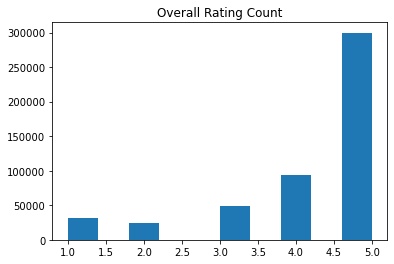

In [92]:
plt.hist(surprise_df['overall'])
plt.title('Overall Rating Count');

In [91]:
ratings_prod_summary = surprise_df.groupby('asin')['overall'].agg(['count', 'mean', 'std'])
ratings_prod_summary.head()

,count,mean,std
asin,,,
0700026398,8,3.125000,1.552648
0700026657,13,3.692308,1.493576
0700099867,30,3.300000,1.643168
0804161380,49,4.816327,0.527315
3828770193,6,4.333333,0.816497


In [94]:
ratings_user_summary = surprise_df.groupby('reviewerID')['overall'].agg(['count', 'mean', 'std'])
ratings_user_summary.head()

,count,mean,std
reviewerID,,,
A0059486XI1Z0P98KP35,5,5.000000,0.000000
A0220159ZRNBTRKLG08H,6,4.666667,0.816497
A0266076X6KPZ6CCHGVS,14,5.000000,0.000000
A0277912HT4JSJKVSL3E,10,4.500000,0.707107
A02836981FYG9912C66F,7,3.714286,0.951190


In [75]:
read = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, read)
train_df, test_df = train_test_split(surprise_data, random_state=42)

In [84]:
train_df

### Baseline

In [19]:
baseline_model1 = NormalPredictor()
baseline_model1.fit(train_df)

In [20]:
prediction1 = baseline_model1.test(test_df)

In [21]:
accuracy.rmse(prediction1)

RMSE: 1.5169


1.5168761365568832

In [22]:
baseline_model2 = BaselineOnly()
baseline_model2.fit(train_df)

Estimating biases using als...


In [23]:
predictions2 = baseline_model2.test(test_df)

In [24]:
accuracy.rmse(predictions2)

RMSE: 1.0447


1.0446509835320532

### KNN

In [62]:
grid_param = {'k':[20, 40, 60]}

In [98]:
raw_ratings = surprise_data.raw_ratings
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings_svd = raw_ratings[:threshold]
B_raw_ratings_svd = raw_ratings[threshold:]
surprise_data.raw_ratings = A_raw_ratings_svd

In [100]:
knn = KNNBasic()
KNN_grid = GridSearchCV(knn, param_grid=grid_param, measures=['rmse'], cv=5)
KNN_grid.fit(surprise_data)

TypeError: 'KNNBasic' object is not callable

### SVD

In [25]:
svd = SVD(random_state=42)
svd.fit(train_df)
prediction_svd = svd.test(test_df)
accuracy.rmse(prediction_svd)

RMSE: 1.0152


1.0151596982698952

In [26]:
svd.predict('A1HP7NVNPFMA4N', '0700026657')

Prediction(uid='A1HP7NVNPFMA4N', iid='0700026657', r_ui=None, est=4.454239721476054, details={'was_impossible': False})